# Top overlapping shell genes by weighted sum for ecoli cohort

In [2]:
import pandas as pd


pd.set_option("display.max_columns", None)
pd.set_option('display.max_colwidth', None)
pd.set_option("display.expand_frame_repr", False)

## Read token information from bed files

In [3]:
import os
import pandas as pd
from pathlib import Path


bedDir = Path(os.environ['GENOMICS_DATA_BASE'], 'genome_nlp_tokens', 'bed_files', 'ECOLI')

bedDfList = []
for bedFile in os.listdir(bedDir):
    tubeid = bedFile.split('.')[0].split('_')[0]
    tokensDf = pd.read_csv(Path(bedDir, bedFile), sep='\t', names=['contig_id', 'start_position', 'end_position', 'tokens', 'score'])
    tokensDf['tube_id'] = tubeid
    bedDfList.append(tokensDf)

bedDf = pd.concat(bedDfList, ignore_index=True)
bedDf

,contig_id,start_position,end_position,tokens,score,tube_id
0,1,1,3,GAA,0.024555,AH21B049
1,1,4,12,AAACCCCGG,0.019281,AH21B049
2,1,13,17,TCAAT,0.042749,AH21B049
3,1,18,22,AAGGC,0.058446,AH21B049
4,1,23,27,CGGGG,-0.002272,AH21B049
...,...,...,...,...,...,...
247349726,5,259913,259920,GCTACCCG,0.012245,ALF22C077
247349727,5,259921,259928,TTGGTGTG,0.000125,ALF22C077
247349728,5,259929,259938,CCTGTTCCGT,-0.000540,ALF22C077
247349729,5,259939,259942,GGCC,0.024973,ALF22C077


<Axes: >

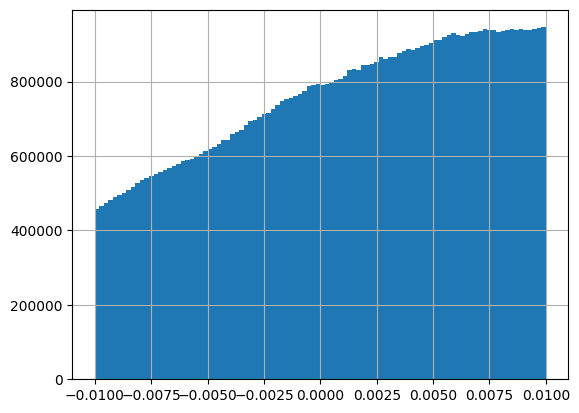

In [4]:
bedDf[(bedDf.score > -0.01) & (bedDf.score < 0.01)].score.hist(bins=100)

In [5]:
bedDf['token_length'] = bedDf.tokens.apply(lambda x: len(x))
bedDf

,contig_id,start_position,end_position,tokens,score,tube_id,token_length
0,1,1,3,GAA,0.024555,AH21B049,3
1,1,4,12,AAACCCCGG,0.019281,AH21B049,9
2,1,13,17,TCAAT,0.042749,AH21B049,5
3,1,18,22,AAGGC,0.058446,AH21B049,5
4,1,23,27,CGGGG,-0.002272,AH21B049,5
...,...,...,...,...,...,...,...
247349726,5,259913,259920,GCTACCCG,0.012245,ALF22C077,8
247349727,5,259921,259928,TTGGTGTG,0.000125,ALF22C077,8
247349728,5,259929,259938,CCTGTTCCGT,-0.000540,ALF22C077,10
247349729,5,259939,259942,GGCC,0.024973,ALF22C077,4


In [6]:
len(bedDf.tokens.unique())

31990

In [7]:
highscoreCutoff = bedDf.score.mean() + 3 * bedDf.score.std()
highscoreCutoff

np.float64(0.10044996853550375)

In [8]:
highscoreDf = bedDf[bedDf.score > highscoreCutoff]
highscoreDf

,contig_id,start_position,end_position,tokens,score,tube_id,token_length
790,1,5456,5461,TTCCGG,0.109817,AH21B049,6
1113,1,7709,7713,CCGAC,0.111683,AH21B049,5
1141,1,7901,7906,GGTTTT,0.126671,AH21B049,6
1147,1,7939,7943,GACAG,0.138056,AH21B049,5
1544,1,10694,10701,CCCGACGG,0.119595,AH21B049,8
...,...,...,...,...,...,...,...
247348343,5,250450,250457,CCCTTTTT,0.104689,ALF22C077,8
247348387,5,250737,250741,ACAGA,0.114884,ALF22C077,5
247349058,5,255352,255357,GAAAAA,0.100641,ALF22C077,6
247349081,5,255503,255508,ACGCTG,0.112193,ALF22C077,6


In [9]:
len(highscoreDf.tokens.unique())

13592

In [10]:
highscoreDf.shape

(3266793, 7)

<Axes: >

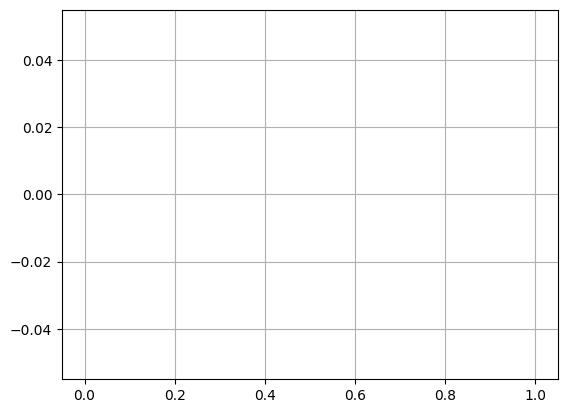

In [11]:
highscoreDf[(highscoreDf.score < 0.05)].score.hist(bins=100)

In [12]:
highscoreDf.token_length.value_counts()

token_length
6     1005832
7      585361
5      449264
8      339503
9      263575
4      262709
3      186469
10      92597
2       40984
11      30865
1        4650
12       2730
16       1991
15        152
13        102
14          9
Name: count, dtype: int64

<Axes: xlabel='token_length', ylabel='Count'>

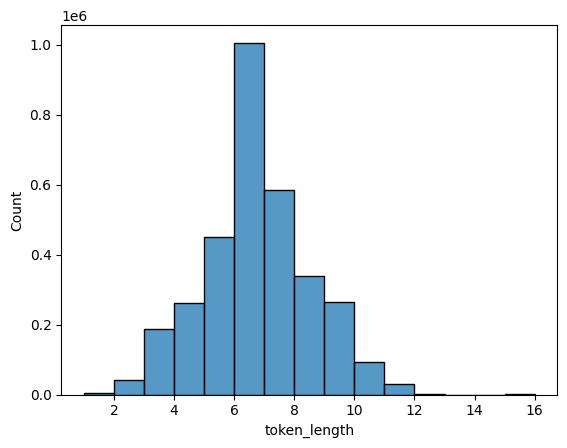

In [13]:
import seaborn as sns

sns.histplot(highscoreDf.token_length, binwidth=1)

## Read shell genes

In [14]:
import os
from pathlib import Path

import pandas as pd


coreGenesPath = Path(os.environ['GENOMICS_DATA_BASE'], 'annotations', 'e_coli', 'panaroo_strict', 'shell_genes.csv')
coreGenesDf = pd.read_csv(coreGenesPath)
coreGenesDf['Gene'] = coreGenesDf.Gene.str.lower()
coreGenesDf

,Gene,Occurrences
0,group_9191,817
1,fimc~~~focc,815
2,lysr~~~pgrr,815
3,rhmd~~~rhmt~~~uhpc~~~yfav,814
4,lysr~~~yqfe,813
...,...,...
2588,group_3988,130
2589,umuc~~~impb,130
2590,group_2837,130
2591,focg,130


## Read bed files containing overlapping tokens and attribution scores

In [15]:
from tqdm import tqdm

import os
import pandas as pd
from pathlib import Path


annotationOverlappingFilesDir = Path(os.environ['GENOMICS_DATA_BASE'], 'genome_nlp_tokens', 'overlapping_with_annotations', 'ECOLI')

annotationOverlappingDfList = []
for annotationOverlappingFile in tqdm(os.listdir(annotationOverlappingFilesDir)):
    df = pd.read_csv(Path(annotationOverlappingFilesDir, annotationOverlappingFile), sep='\t', names=['contig_id', 'start_position', 'end_position', 'tokens', 'score', 'feature_type', 'id', 'name', 'gene', 'atributes'])
    df = df[df.feature_type.isin(['CDS', 'ncRNA', 'oriC', 'regulatory_region', 'oriT'])]
    df['tube_code'] = [annotationOverlappingFile.split('_')[0]]*df.shape[0]
    df = df[df.tokens.apply(lambda x: (len(x) >= 5))].reset_index()
    df['gene'] = df.gene.str.lower()
    coreDf = df[df.gene.isin(coreGenesDf.Gene)]
    annotationOverlappingDfList.append(coreDf)
annotationOverlappingDf = pd.concat(annotationOverlappingDfList, ignore_index=True)
annotationOverlappingDf = annotationOverlappingDf.drop_duplicates()
annotationOverlappingDf


  0%|          | 0/358 [00:00<?, ?it/s]

100%|██████████| 358/358 [04:26<00:00,  1.34it/s]


,index,contig_id,start_position,end_position,tokens,score,feature_type,id,name,gene,atributes,tube_code
0,0,1,665,671,GAATCAT,0.037687,CDS,IGMLFD_00005,Uncharacterized deacetylase YaiS,yais,"ID=IGMLFD_00005;Name=Uncharacterized deacetylase YaiS;locus_tag=IGMLFD_00005;product=Uncharacterized deacetylase YaiS;Dbxref=COG:COG2120,COG:G,EC:3.-.-.-,GO:0016811,RefSeq:WP_000362014.1,SO:0001217,UniParc:UPI0000DACD3F,UniRef:UniRef100_A0A0D8VZB7,UniRef:UniRef50_P71311,UniRef:UniRef90_P71311;gene=yaiS",AH19C036
1,1,1,672,680,TTTATGAAT,0.023426,CDS,IGMLFD_00005,Uncharacterized deacetylase YaiS,yais,"ID=IGMLFD_00005;Name=Uncharacterized deacetylase YaiS;locus_tag=IGMLFD_00005;product=Uncharacterized deacetylase YaiS;Dbxref=COG:COG2120,COG:G,EC:3.-.-.-,GO:0016811,RefSeq:WP_000362014.1,SO:0001217,UniParc:UPI0000DACD3F,UniRef:UniRef100_A0A0D8VZB7,UniRef:UniRef50_P71311,UniRef:UniRef90_P71311;gene=yaiS",AH19C036
2,3,1,684,689,AAAACC,0.024358,CDS,IGMLFD_00005,Uncharacterized deacetylase YaiS,yais,"ID=IGMLFD_00005;Name=Uncharacterized deacetylase YaiS;locus_tag=IGMLFD_00005;product=Uncharacterized deacetylase YaiS;Dbxref=COG:COG2120,COG:G,EC:3.-.-.-,GO:0016811,RefSeq:WP_000362014.1,SO:0001217,UniParc:UPI0000DACD3F,UniRef:UniRef100_A0A0D8VZB7,UniRef:UniRef50_P71311,UniRef:UniRef90_P71311;gene=yaiS",AH19C036
3,4,1,690,698,TTCACCCAG,0.031550,CDS,IGMLFD_00005,Uncharacterized deacetylase YaiS,yais,"ID=IGMLFD_00005;Name=Uncharacterized deacetylase YaiS;locus_tag=IGMLFD_00005;product=Uncharacterized deacetylase YaiS;Dbxref=COG:COG2120,COG:G,EC:3.-.-.-,GO:0016811,RefSeq:WP_000362014.1,SO:0001217,UniParc:UPI0000DACD3F,UniRef:UniRef100_A0A0D8VZB7,UniRef:UniRef50_P71311,UniRef:UniRef90_P71311;gene=yaiS",AH19C036
4,5,1,699,708,ATCGCTATTG,0.008409,CDS,IGMLFD_00005,Uncharacterized deacetylase YaiS,yais,"ID=IGMLFD_00005;Name=Uncharacterized deacetylase YaiS;locus_tag=IGMLFD_00005;product=Uncharacterized deacetylase YaiS;Dbxref=COG:COG2120,COG:G,EC:3.-.-.-,GO:0016811,RefSeq:WP_000362014.1,SO:0001217,UniParc:UPI0000DACD3F,UniRef:UniRef100_A0A0D8VZB7,UniRef:UniRef50_P71311,UniRef:UniRef90_P71311;gene=yaiS",AH19C036
...,...,...,...,...,...,...,...,...,...,...,...,...
6908033,301754,5,356550,356554,TTGCA,0.009684,CDS,KCGHAI_11835,Proteasome lid subunit RPN8/RPN11%2C contains Jab1/MPN domain metalloenzyme (JAMM) motif,rri1,"ID=KCGHAI_11835;Name=Proteasome lid subunit RPN8/RPN11%2C contains Jab1/MPN domain metalloenzyme (JAMM) motif;locus_tag=KCGHAI_11835;product=Proteasome lid subunit RPN8/RPN11%2C contains Jab1/MPN domain metalloenzyme (JAMM) motif;Dbxref=COG:COG1310,COG:O,SO:0001217,UniRef:UniRef50_A0A2X1NVC3,UniRef:UniRef90_Q320M2;gene=rri1",AH19F069
6908034,301755,5,356555,356564,ACGATTTGGC,0.031790,CDS,KCGHAI_11835,Proteasome lid subunit RPN8/RPN11%2C contains Jab1/MPN domain metalloenzyme (JAMM) motif,rri1,"ID=KCGHAI_11835;Name=Proteasome lid subunit RPN8/RPN11%2C contains Jab1/MPN domain metalloenzyme (JAMM) motif;locus_tag=KCGHAI_11835;product=Proteasome lid subunit RPN8/RPN11%2C contains Jab1/MPN domain metalloenzyme (JAMM) motif;Dbxref=COG:COG1310,COG:O,SO:0001217,UniRef:UniRef50_A0A2X1NVC3,UniRef:UniRef90_Q320M2;gene=rri1",AH19F069
6908035,301756,5,356565,356571,CGCCGCA,0.013830,CDS,KCGHAI_11835,Proteasome lid subunit RPN8/RPN11%2C contains Jab1/MPN domain metalloenzyme (JAMM) motif,rri1,"ID=KCGHAI_11835;Name=Proteasome lid subunit RPN8/RPN11%2C contains Jab1/MPN domain metalloenzyme (JAMM) motif;locus_tag=KCGHAI_11835;product=Proteasome lid subunit RPN8/RPN11%2C contains Jab1/MPN domain metalloenzyme (JAMM) motif;Dbxref=COG:COG1310,COG:O,SO:0001217,UniRef:UniRef50_A0A2X1NVC3,UniRef:UniRef90_Q320M2;gene=rri1",AH19F069
6908036,301757,5,356572,356579,TCGACCTT,0.011420,CDS,KCGHAI_11835,Proteasome lid subunit RPN8/RPN11%2C contains Jab1/MPN domain metalloenzyme (JAMM) motif,rri1,"ID=KCGHAI_11835;Name=Proteasome lid subunit RPN8/RPN11%2C contains Jab1/MPN domain metalloenzyme (JAMM) motif;locus_tag=KCGHAI_11835;product=Proteasome lid subunit RPN8/RPN11%2C conta

In [16]:
overlappingDf = annotationOverlappingDf[['contig_id', 'start_position', 'end_position', 'tokens', 'score', 'gene', 'name', 'tube_code']].drop_duplicates()
overlappingDf

,contig_id,start_position,end_position,tokens,score,gene,name,tube_code
0,1,665,671,GAATCAT,0.037687,yais,Uncharacterized deacetylase YaiS,AH19C036
1,1,672,680,TTTATGAAT,0.023426,yais,Uncharacterized deacetylase YaiS,AH19C036
2,1,684,689,AAAACC,0.024358,yais,Uncharacterized deacetylase YaiS,AH19C036
3,1,690,698,TTCACCCAG,0.031550,yais,Uncharacterized deacetylase YaiS,AH19C036
4,1,699,708,ATCGCTATTG,0.008409,yais,Uncharacterized deacetylase YaiS,AH19C036
...,...,...,...,...,...,...,...,...
6908033,5,356550,356554,TTGCA,0.009684,rri1,Proteasome lid subunit RPN8/RPN11%2C contains Jab1/MPN domain metalloenzyme (JAMM) motif,AH19F069
6908034,5,356555,356564,ACGATTTGGC,0.031790,rri1,Proteasome lid subunit RPN8/RPN11%2C contains Jab1/MPN domain metalloenzyme (JAMM) motif,AH19F069
6908035,5,356565,356571,CGCCGCA,0.013830,rri1,Proteasome lid subunit RPN8/RPN11%2C contains Jab1/MPN domain metalloenzyme (JAMM) motif,AH19F069
6908036,5,356572,356579,TCGACCTT,0.011420,rri1,Proteasome lid subunit RPN8/RPN11%2C contains Jab1/MPN domain metalloenzyme (JAMM) motif,AH19F069


## Get overlapping genes for high-score tokens

In [17]:
highscoreTokenOverlapsDf = overlappingDf.merge(
    highscoreDf[['contig_id', 'start_position', 'end_position', 'tokens']],
    on=['contig_id', 'start_position', 'end_position', 'tokens'],
    how='inner',
)
highscoreTokenOverlapsDf

,contig_id,start_position,end_position,tokens,score,gene,name,tube_code
0,1,101560,101565,AACATT,0.116145,acrr,multidrug efflux transporter transcriptional repressor AcrR,AH19C036
1,1,101560,101565,AACATT,0.116145,acrr,multidrug efflux transporter transcriptional repressor AcrR,AH19C036
2,1,101560,101565,AACATT,0.116145,acrr,multidrug efflux transporter transcriptional repressor AcrR,AH19C036
3,1,101560,101565,AACATT,0.116145,acrr,multidrug efflux transporter transcriptional repressor AcrR,AH19C036
4,1,101560,101565,AACATT,0.116145,acrr,multidrug efflux transporter transcriptional repressor AcrR,AH19C036
...,...,...,...,...,...,...,...,...
161683,5,320681,320686,CTGTTC,0.141868,intq,Putative defective protein IntQ,AH19F069
161684,5,320687,320693,TGCCATA,0.145630,intq,Putative defective protein IntQ,AH19F069
161685,5,320718,320723,ATGCTC,0.152306,intq,Putative defective protein IntQ,AH19F069
161686,5,320934,320940,AGAAACA,0.202396,intq,Putative defective protein IntQ,AH19F069


## Calculate weighted sum for all the genes overlapping with high-score tokens

In [18]:
import numpy as np


geneWeightedsumDf = highscoreTokenOverlapsDf.groupby(by=['gene']).agg({'score': np.sum}).reset_index().rename(columns={'score': 'weighted_sum'})
geneWeightedsumDf

/tmp/ipykernel_34589/2423154480.py:4: FutureWarning: The provided callable <function sum at 0x70d9d8d94280> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  geneWeightedsumDf = highscoreTokenOverlapsDf.groupby(by=['gene']).agg({'score': np.sum}).reset_index().rename(columns={'score': 'weighted_sum'})


,gene,weighted_sum
0,abc2,2.532265
1,abga,4.153079
2,abgb,7.427457
3,abgr,2.640673
4,abgt,3.292677
...,...,...
535,yqeh,4.758125
536,yqej,5.305280
537,yqek,2.140781
538,yrha,2.716068


## Visualise weighted sum

<Axes: xlabel='weighted_sum', ylabel='Count'>

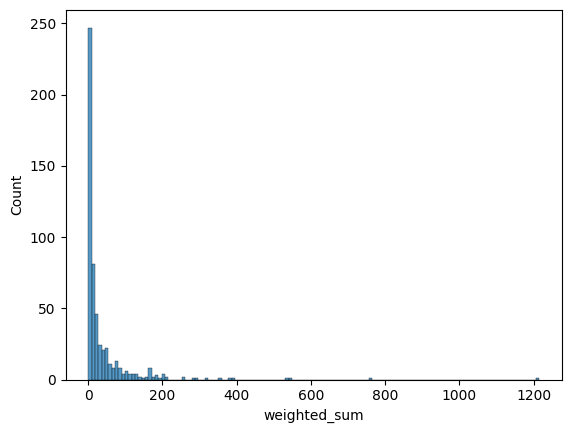

In [19]:
import seaborn as sns


sns.histplot(geneWeightedsumDf.weighted_sum)

## Top genes based on the weighted sum

In [20]:
weightedsumCutoff = geneWeightedsumDf.weighted_sum.mean() + (2 * geneWeightedsumDf.weighted_sum.std())
weightedsumCutoff

np.float64(212.42215179735956)

In [21]:
geneWeightedsumDf[geneWeightedsumDf.weighted_sum > weightedsumCutoff].sort_values(by=['weighted_sum'], ascending=False)

,gene,weighted_sum
45,ccma,1214.694417
419,xylg,756.155570
389,suca,547.508293
137,fepa,531.010088
138,fepd,387.780823
139,fhue,381.431815
383,sinh,358.408232
24,asst,322.393508
18,araj,296.023534
387,spef,282.620851


## Create gene-type lookup table from amrfinderplus annotations

In [22]:
import os

import pandas as pd

from pathlib import Path


amrfinderDir = Path(os.environ['GENOMICS_DATA_BASE'], 'amrfinder')

amrfinderDfList = []
for amrfinderFile in os.listdir(amrfinderDir):
    amrfinderDf = pd.read_csv(Path(amrfinderDir, amrfinderFile), sep='\t')
    amrfinderDfList.append(amrfinderDf)

allAmrfinderDf = pd.concat(amrfinderDfList, ignore_index=True)
allAmrfinderDf

/tmp/ipykernel_34589/536070399.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  allAmrfinderDf = pd.concat(amrfinderDfList, ignore_index=True)


,Protein identifier,Contig id,Start,Stop,Strand,Gene symbol,Sequence name,Scope,Element type,Element subtype,Class,Subclass,Method,Target length,Reference sequence length,% Coverage of reference sequence,% Identity to reference sequence,Alignment length,Accession of closest sequence,Name of closest sequence,HMM id,HMM description
0,NaN,1,83926,85452,-,aur,zinc metalloproteinase aureolysin,plus,VIRULENCE,VIRULENCE,NaN,NaN,BLASTX,509,509,100.00,99.41,509,EHO93748.1,zinc metalloproteinase aureolysin,NaN,NaN
1,NaN,1,128415,129464,+,icaC,polysaccharide intercellular adhesin biosynthesis/export protein IcaC,plus,VIRULENCE,VIRULENCE,NaN,NaN,EXACTX,350,350,100.00,100.00,350,AUU58561.1,polysaccharide intercellular adhesin biosynthesis/export protein IcaC,NaN,NaN
2,NaN,1,150950,154498,-,cna,collagen adhesin Cna,plus,VIRULENCE,VIRULENCE,NaN,NaN,BLASTX,1183,1183,100.00,98.31,1183,BAB96477.1,collagen adhesin Cna,NaN,NaN
3,NaN,1,277464,278813,+,tet(38),tetracycline efflux MFS transporter Tet(38),core,AMR,AMR,TETRACYCLINE,TETRACYCLINE,EXACTX,450,450,100.00,100.00,450,WP_001100300.1,tetracycline efflux MFS transporter Tet(38),NaN,NaN
4,NaN,1,505300,506652,+,mepA,multidrug efflux MATE transporter MepA,plus,AMR,AMR,EFFLUX,EFFLUX,BLASTX,451,451,100.00,99.33,451,BAB41547.1,multidrug efflux MATE transporter MepA,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57610,NaN,17,83399,84580,-,emrD,multidrug efflux MFS transporter EmrD,plus,AMR,AMR,EFFLUX,EFFLUX,BLASTX,394,394,100.00,99.24,394,ACN65732.1,multidrug efflux MFS transporter EmrD,NaN,NaN
57611,NaN,2,213498,214724,-,kdeA,multidrug efflux MFS transporter KdeA,plus,AMR,AMR,EFFLUX,EFFLUX,BLASTX,409,410,99.76,99.02,409,ABR76310.1,multidrug efflux MFS transporter KdeA,NaN,NaN
57612,NaN,3,59710,60882,+,oqxA,multidrug efflux RND transporter periplasmic adaptor subunit OqxA,core,AMR,AMR,PHENICOL/QUINOLONE,PHENICOL/QUINOLONE,BLASTX,391,391,100.00,99.23,391,WP_002914189.1,multidrug efflux RND transporter periplasmic adaptor subunit OqxA,NaN,NaN
57613,NaN,3,60909,64058,+,oqxB9,multidrug efflux RND transporter permease subunit OqxB9,core,AMR,AMR,PHENICOL/QUINOLONE,PHENICOL/QUINOLONE,ALLELEX,1050,1050,100.00,100.00,1050,WP_012967412.1,multidrug efflux RND transporter permease subunit OqxB9,NaN,NaN


In [23]:
genetypeLookupDf = allAmrfinderDf[['Gene symbol', 'Element type']].drop_duplicates()
genetypeLookupDf['Gene symbol'] = genetypeLookupDf['Gene symbol'].str.lower()
genetypeLookupDf

,Gene symbol,Element type
0,aur,VIRULENCE
1,icac,VIRULENCE
2,cna,VIRULENCE
3,tet(38),AMR
4,mepa,AMR
...,...,...
55837,blapdc-58,AMR
56358,blaact-49,AMR
56951,blandm-4,AMR
56963,aac(6')-ib-cr,AMR


## Read vfdb info

In [24]:
import os
import pandas as pd
from pathlib import Path


vfdbInfoFile = Path(os.environ['GENOMICS_DATA_BASE'], 'misc', 'VFDB_info.csv')
vfdbInfoDf = pd.read_csv(vfdbInfoFile)
vfdbInfoDf['Label'] = vfdbInfoDf['Label'].str.lower()
vfdbInfoDf

,Column,ID,Label,Description,Source,Class
0,1,c0393,vat,hemoglobin protease,Escherichia coli O6:K2:H1 CFT073 (UPEC),Autotransporters
1,2,APECO1_O1CoBM73,tsh,Tsh,Escherichia coli O1:K1:H7 (APEC),Autotransporters
2,3,Q673F0_ECOLX,rpea,putative SPATE autotransporter; similar to the SPATE proteins,Escherichia coli plasmid pRAP strain REPEC 83/39,Autotransporters
3,4,ECSF_4010,ecsf_4010,phage protein,Escherichia coli SE15,Autotransporters
4,5,EcSMS35_3921,ecsms35_3921,outer membrane autotransporter,Escherichia coli SMS-3-5 (environmental),Autotransporters
...,...,...,...,...,...,...
249,250,c5077,yddo,ABC transporter ATP-binding protein,Escherichia coli O6:K2:H1 CFT073 (UPEC),UPEC specific genes
250,251,c5078,c5078,oligopeptide ABC transporter,Escherichia coli O6:K2:H1 CFT073 (UPEC),UPEC specific genes
251,252,c5079,yddq,ABC transporter permease,Escherichia coli O6:K2:H1 CFT073 (UPEC),UPEC specific genes
252,253,c5080,yddr,ABC transporter permease,Escherichia coli O6:K2:H1 CFT073 (UPEC),UPEC specific genes


## Read vf collection

In [25]:
import os
import pandas as pd
from pathlib import Path


vfCollectionDescriptionFile = Path(os.environ['GENOMICS_DATA_BASE'], 'misc', 'ecoli_VF_collection_description.tsv')
vfCollectionDescriptionDf = pd.read_csv(vfCollectionDescriptionFile, sep='\t')
vfCollectionDescriptionDf['gene'] = vfCollectionDescriptionDf['gene'].str.lower()
vfCollectionDescriptionDf

,gene,locus tag,accession number (protein_id),description,reference,source,class
0,aap,EC042_pAA055,NaN,dispersin,Escherichia coli O44:H18 042 plasmid pAA (EAEC),VFDB R2,Adhesion_invasion
1,aata,EC042_pAA008,NaN,dispersin secretion locus ABC transporter,Escherichia coli O44:H18 042 plasmid pAA (EAEC),VFDB R2,Adhesion_invasion
2,aatb,EC042_pAA009,NaN,dispersin secretion locus ABC transporter,Escherichia coli O44:H18 042 plasmid pAA (EAEC),VFDB R2,Adhesion_invasion
3,aatc,EC042_pAA010,NaN,dispersin secretion locus ABC transporter,Escherichia coli O44:H18 042 plasmid pAA (EAEC),VFDB R2,Adhesion_invasion
4,aatd,EC042_pAA011,NaN,dispersin secretion locus ABC transporter,Escherichia coli O44:H18 042 plasmid pAA (EAEC),VFDB R2,Adhesion_invasion
...,...,...,...,...,...,...,...
1064,lngj,NaN,ABU50049,"longus pili, coli surface antigen CS20",Escherichia coli O8:H9 E9034A (ETEC),VFDB R3,Type_4_pilus
1065,lngp,NaN,ABU50050,"longus pili, coli surface antigen CS20",Escherichia coli O8:H9 E9034A (ETEC),VFDB R3,Type_4_pilus
1066,etsa,APECO1_O1CoBM197,YP_001481352,ABC transporter,Escherichia coli O1:K1:H7 APEC O1 plasmid pAPEC-O1-ColBM (APEC),manually,Other_virulence_gene
1067,etsb,APECO1_O1CoBM198,YP_001481353,ABC transporter,Escherichia coli O1:K1:H7 APEC O1 plasmid pAPEC-O1-ColBM (APEC),manually,Other_virulence_gene


## Read ABRicate

In [26]:
import os
import pandas as pd
from pathlib import Path


abricateFile = Path(os.environ['GENOMICS_DATA_BASE'], 'misc', 'ABRicate.csv')
abricateDf = pd.read_csv(abricateFile)
abricateDf['gene'] = abricateDf['gene'].str.lower()
abricateDf

,gene,type
0,aaa23990,heat-stable enterotoxin
1,aaa24093,heat labile enterotoxin type IIa A
2,aaa24094,heat labile enterotoxin type IIa B
3,apeco1_1753,hypothetical protein
4,apeco1_1761,hypothetical protein
...,...,...
2696,ygeh,transcriptional regulator
2697,yggr,
2698,yghg,
2699,yijp,


## Add gene descriptions to the top genes

In [27]:
import pandas as pd

pd.set_option('display.max_rows', None)


geneWeightedsumDf[geneWeightedsumDf.weighted_sum > weightedsumCutoff].sort_values(by=['weighted_sum'], ascending=False).merge(
    highscoreTokenOverlapsDf[['gene', 'name']].drop_duplicates(),
    on=['gene'],
    how='inner'
).merge(
    genetypeLookupDf,
    left_on=['gene'],
    right_on=['Gene symbol'],
    how='left'
).rename(
    columns={'Element type': 'AMR Finder Type'}
).merge(
    vfdbInfoDf,
    left_on=['gene'],
    right_on=['Label'],
    how='left'
).rename(
    columns={'Class': 'VFDB Type'}
).merge(
    vfCollectionDescriptionDf,
    on=['gene'],
    how='left'
).rename(
    columns={'class': 'VF Collection Type'}
)[['gene', 'name', 'weighted_sum', 'AMR Finder Type', 'VFDB Type', 'VF Collection Type']].drop_duplicates(subset=['gene', 'weighted_sum', 'AMR Finder Type', 'VFDB Type', 'VF Collection Type'])

,gene,name,weighted_sum,AMR Finder Type,VFDB Type,VF Collection Type
0,ccma,cytochrome c biogenesis heme-transporting ATPase CcmA,1214.694417,NaN,NaN,NaN
2,xylg,D-xylose ABC transporter ATP-binding protein,756.155570,NaN,NaN,NaN
4,suca,2-oxoglutarate dehydrogenase E1 component,547.508293,NaN,UPEC specific genes,NaN
5,fepa,ferrienterobactin outer membrane transporter,531.010088,NaN,Iron uptake,Iron_uptake
7,fepd,ABC-type Fe3+-siderophore transport system%2C permease component,387.780823,NaN,NaN,Iron_uptake
9,fhue,ferric-rhodotorulic acid/ferric-coprogen receptor FhuE,381.431815,NaN,Iron uptake,Iron_uptake
11,sinh,intimin-like inverse autotransporter SinH,358.408232,NaN,NaN,NaN
12,asst,Arylsulfate sulfotransferase AssT,322.393508,NaN,UPEC specific genes,NaN
13,araj,putative arabinose efflux permease AraJ%2C MFS family,296.023534,NaN,NaN,NaN
16,spef,ornithine decarboxylase SpeF,282.620851,NaN,NaN,NaN


## Save all gene hits

In [28]:
import os
import pandas as pd
from pathlib import Path


outputFile = Path(os.environ['GENOMICS_DATA_BASE'], 'temp', 'ecoli_top_shell_genes_all_overlaping_3sd_tokens.csv')
geneWeightedsumDf.sort_values(by=['weighted_sum'], ascending=False).merge(
    highscoreTokenOverlapsDf[['gene', 'name']].drop_duplicates(),
    on=['gene'],
    how='inner'
).merge(
    genetypeLookupDf,
    left_on=['gene'],
    right_on=['Gene symbol'],
    how='left'
).rename(
    columns={'Element type': 'AMR Finder Type'}
).merge(
    vfdbInfoDf,
    left_on=['gene'],
    right_on=['Label'],
    how='left'
).rename(
    columns={'Class': 'VFDB Type'}
).merge(
    vfCollectionDescriptionDf,
    on=['gene'],
    how='left'
).rename(
    columns={'class': 'VF Collection Type'}
)[['gene', 'name', 'weighted_sum', 'AMR Finder Type', 'VFDB Type', 'VF Collection Type']].drop_duplicates().to_csv(outputFile, index=False)